In [1]:
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

from cifar10 import get_dataset, get_model, CIFAR10Loss

In [2]:
SEED = 42

In [3]:
baseline = get_model()
baseline.load_state_dict(torch.load(f'models/cifar10_pretrained_seed={SEED}.pth'))
ks = [500, 1000, 1500, 2000, 2500]
factor_strategies = ['random', 'identity', 'ekfac']
models = {}
loss = CIFAR10Loss()

for factor_strategy in factor_strategies:
    for k in ks:
        model = get_model()
        model.load_state_dict(torch.load(f'models/{factor_strategy}/cifar10_pretrained_seed={SEED}_k={k}.pth'))
        models[(factor_strategy, k)] = model

In [4]:
def get_accuracy_and_loss(model, dataset):
    correct = 0
    loss_val = 0
    total = 0
    data_loader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=False)
    model = model.cuda()
    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.cuda(), labels.cuda()
            outputs = model(inputs)
            loss_val += torch.nn.functional.cross_entropy(outputs, labels).item() * labels.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    model = model.cpu()
    print(total)
    return correct / total, loss_val / total

In [5]:
# evaluate baseline
test_dataset = get_dataset('test')
baseline_accuracy, baseline_loss = get_accuracy_and_loss(baseline, test_dataset)
print(f'Baseline accuracy: {baseline_accuracy:.4f} loss: {baseline_loss:.4f}')

Files already downloaded and verified
10000
Baseline accuracy: 0.7203 loss: 0.8866


In [6]:
model_accuracies = {}
model_losses = {}

# evaluate models
for (factor_strategy, k), model in tqdm(models.items()):
    accuracy, loss_val = get_accuracy_and_loss(model, test_dataset)
    model_accuracies[(factor_strategy, k)] = accuracy
    model_losses[(factor_strategy, k)] = loss_val
    print(f'{factor_strategy} k={k} accuracy: {accuracy:.4f} loss: {loss_val:.4f}')

  7%|▋         | 1/15 [00:01<00:24,  1.76s/it]

10000
random k=500 accuracy: 0.7360 loss: 0.9847


 13%|█▎        | 2/15 [00:03<00:22,  1.73s/it]

10000
random k=1000 accuracy: 0.7381 loss: 0.9660


 20%|██        | 3/15 [00:05<00:20,  1.73s/it]

10000
random k=1500 accuracy: 0.7482 loss: 0.9311


 27%|██▋       | 4/15 [00:06<00:19,  1.73s/it]

10000
random k=2000 accuracy: 0.7408 loss: 0.9815


 33%|███▎      | 5/15 [00:08<00:17,  1.73s/it]

10000
random k=2500 accuracy: 0.7611 loss: 0.8639


 40%|████      | 6/15 [00:10<00:15,  1.72s/it]

10000
identity k=500 accuracy: 0.7220 loss: 1.0118


 47%|████▋     | 7/15 [00:12<00:13,  1.72s/it]

10000
identity k=1000 accuracy: 0.7274 loss: 0.9900


 53%|█████▎    | 8/15 [00:13<00:11,  1.71s/it]

10000
identity k=1500 accuracy: 0.7432 loss: 0.9748


 60%|██████    | 9/15 [00:15<00:10,  1.71s/it]

10000
identity k=2000 accuracy: 0.7562 loss: 0.9175


 67%|██████▋   | 10/15 [00:17<00:08,  1.70s/it]

10000
identity k=2500 accuracy: 0.7674 loss: 0.8879


 73%|███████▎  | 11/15 [00:18<00:06,  1.70s/it]

10000
ekfac k=500 accuracy: 0.7151 loss: 1.0302


 80%|████████  | 12/15 [00:20<00:05,  1.70s/it]

10000
ekfac k=1000 accuracy: 0.7436 loss: 0.9426


 87%|████████▋ | 13/15 [00:22<00:03,  1.71s/it]

10000
ekfac k=1500 accuracy: 0.7302 loss: 0.9759


 93%|█████████▎| 14/15 [00:23<00:01,  1.71s/it]

10000
ekfac k=2000 accuracy: 0.7485 loss: 0.9028


100%|██████████| 15/15 [00:25<00:00,  1.71s/it]

10000
ekfac k=2500 accuracy: 0.7585 loss: 0.9193


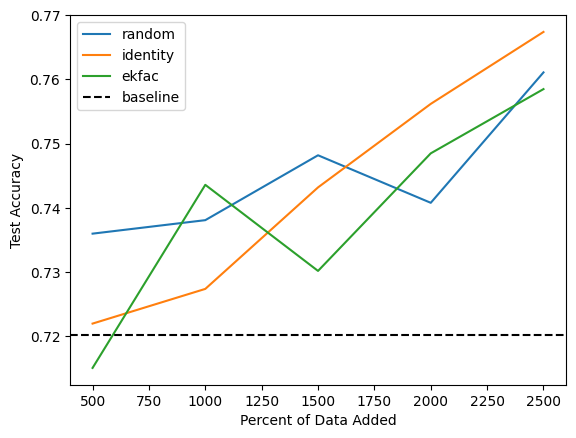

In [7]:
for factor_strategy in factor_strategies:
    accuracies = [model_accuracies[(factor_strategy, k)] for k in ks]
    plt.plot(ks, accuracies, label=factor_strategy)
plt.axhline(baseline_accuracy, color='black', linestyle='--', label='baseline')
plt.xlabel('Percent of Data Added')
plt.ylabel('Test Accuracy')
plt.legend()

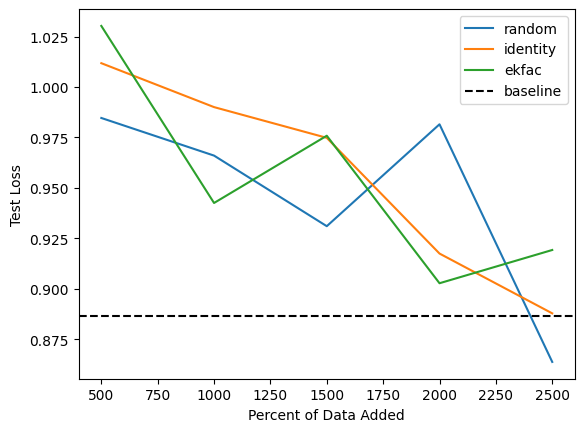

In [8]:
for factor_strategy in factor_strategies:
    losses = [model_losses[(factor_strategy, k)] for k in ks]
    plt.plot(ks, losses, label=factor_strategy)
plt.axhline(baseline_loss, color='black', linestyle='--', label='baseline')
plt.xlabel('Percent of Data Added')
plt.ylabel('Test Loss')
plt.legend()